# Large Matrix Factorization on the MovieLens Dataset

This time we'll be using the latest MovieLens dataset, which contains about 300k users, 50k movies, and 28M ratings. That's obviously a LOT larger than the 100k dataset, so we've adapted the code a bit.

The completed matrix would be of shape (300k,50k), which amounts to 15B cells. That will OBVIOUSLY not fit in memory, so it's important to make our predictions one at a time, and save them in some text file. 

## Importing the Data

Instead of building a sparse matrix (which is not ultimately necessary to do matrix factorization), we're simply importing arrays of users, movies, and ratings. These arrays have the same length, and for any index i, 
    
    users[i] has given movies[i] a note of ratings[i]

In [62]:
import time
import numpy as np
import pickle as pkl

start = time.time()

filename = 'ml-latest/ratings.csv'
data_file = open(filename,'r')

users,movies,ratings = list(),list(),list()
for line in data_file.readlines():
    line = line.split(',')
    users.append(line[0])
    movies.append(line[1])
    ratings.append(line[2])

users = np.array(users).astype(int)
movies = np.array(movies).astype(int)
ratings = np.array(ratings).astype(float)
    
unique_users = np.unique(users)
unique_movies = np.unique(movies)
    
n = len(unique_users)
m = len(unique_movies)

user_to_id = dict(zip(unique_users,range(n)))
id_to_user = dict(zip(range(n),unique_users))
movie_to_id = dict(zip(unique_movies,range(m)))
id_to_movie = dict(zip(range(m),unique_movies))
    
print('Number of users:',n)
print('Number of movies:',m)
print('Number of ratings:',len(ratings))
print('Data loaded in',np.round(time.time()-start,2),'seconds')

Number of users: 283228
Number of movies: 53889
Number of ratings: 27753444
Data loaded in 59.03 seconds


### Dividing into Training / Testing Data

We could just divide our data into two groups by picking an index and splitting each array into two at that index, but the users and movies being in numerical order, that would mean we would completely ignore information about the last users in our dataset, and that would harm our predictions for them. 

So instead what we're doing is picking n_train indices at random, adding them to the training set, and then using all the remaining indices for testing. 

When you actually use matrix factorization, you can disregard this step as you'll want to use all your data to train your model. This is just so we can tune our parameters. 

In [63]:
start = time.time()

# split: proportion of the data used for training
# split = .8 means we use 80% of the data for training
split = .8

n_train = int(len(ratings)*split)
all_indices = np.arange(len(ratings))
# It's important to make our choice of learning data random.
# If we just split it with no shuffle, we'll be completely ignoring certain users and items.
train_indices = np.random.choice(all_indices,n_train,replace=False)
test_indices = np.setdiff1d(all_indices,train_indices)

print(len(train_indices),'training samples ready')
print(len(test_indices),'testing samples ready')
print('Train / test division made in',np.round(time.time()-start,2),'seconds')

22202755 training samples ready
5550689 testing samples ready
Train / test division made in 7.03 seconds


## Normalization: Global Average

We're going to try and center our data to 0, which always makes it easier for models to fit the data. 

In [64]:
start = time.time()
average_rating = np.mean(ratings)
normalized_ratings = ratings - average_rating
print('Data normalized in',np.round(time.time()-start,2),'seconds')

Data normalized in 0.07 seconds


## Initialization and Metric Definition

The initialization is pretty standard: we build random matrices for our latent representations of users and movies, and random vectors for our user and movie biases. 

I've chosen to use the mean absolute error to print out, only because it's just so much easier to interpret. In the calculations though, I use the MSE to train the model. We're going to measure the train and test error at each iteration (which we won't do once the model is actually running), so it's important to know how long it takes to compute, so we can make an estimate of how much time our model will take once it's trained and running without measuring its own error.

In [65]:
# matrices and vectors used for factorization initialized randomly
K = 3
start = time.time()
p = np.random.rand(n,K)
q = np.random.rand(m,K)
user_bias = np.random.rand(n)
movie_bias = np.random.rand(m)
print('Time to initiate matrices and bias vectors:',np.round(time.time()-start,2),'seconds')

def mean_absolute_error(indices):
    error = 0
    for i in indices:
        user = user_to_id[users[i]]
        movie = movie_to_id[movies[i]]
        # leaving out the average rating because it doesn't change our error
        error += abs(normalized_ratings[i] - (np.dot(p[user],q[movie])+user_bias[user]+movie_bias[movie]))
    return error/len(indices)

start = time.time()
error_train = mean_absolute_error(train_indices)
print('Time to calculate train error:',np.round(time.time()-start,2),'seconds')

start = time.time()
error_test = mean_absolute_error(test_indices)
print('Time to calculate test error:',np.round(time.time()-start,2),'seconds')

Time to initiate matrices and bias vectors: 0.03 seconds
Time to calculate train error: 58.13 seconds
Time to calculate test error: 12.36 seconds


## Training the Model

This is where the magic happens.

We're training on the normalized data, which has had the average rating removed, and is thus centered around 0. We are learning our matrices as well as the user and movie biases. The updating equations are derived from the MSE gradient. 

Remember we're computing and saving the error at each iteration, which takes a significant amount of time and will not be happening once the model is running. 

The bigger K gets, the longer iterations will run for, so I would suggest keeping it under 10. We can obtain some pretty accurate predictions with low values, as they also prevent overfitting. 


Mean absolute error at iteration 0: (time = 0.00023555755615234375 )
	Train: 1.7993910620610978 	Test: 1.7988811835030432

Mean absolute error at iteration 1: (time = 386.4166028499603 )
	Train: 0.6718306089662365 	Test: 0.6775945743257356

Mean absolute error at iteration 2: (time = 759.9310350418091 )
	Train: 0.6558112618601198 	Test: 0.6639152982489344


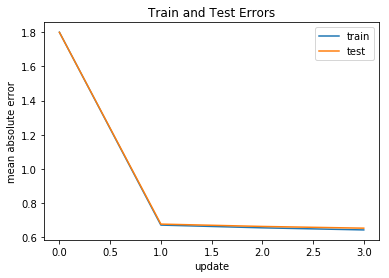

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

################################################
################## PARAMETERS ##################
################################################

# alpha: learning rate
# show_every: number of iterations between 2 prints of the error
# error_threshold: stop the loop if the test_error goes under that threshold
# max_time: stop the loop if it's been running for longer than that time (in seconds)
# beta: regularization coefficient
alpha = .01
show_every = 1
error_threshold = .1
max_time = 900
beta = .1


#################################################
################# TRAINING LOOP #################
#################################################

# saving errors so we can plot them
train_errors = [error_train]
test_errors = [error_test]

start = time.time()
iter=0

while error_test > error_threshold and time.time()-start<max_time:
    # To see error at each iteration, uncomment:
    if iter%show_every==0:
        print('\nMean absolute error at iteration',str(iter)+': (time =',time.time()-start,')') 
        print('\tTrain:',error_train,'\tTest:',error_test)
    iter+=1
    for i in train_indices: 
        user = user_to_id[users[i]]
        movie = movie_to_id[movies[i]]
        local_error = normalized_ratings[i] - (np.dot(p[user],q[movie]) + user_bias[user] + movie_bias[movie])
        p[user] += alpha*(2*local_error*q[movie] - beta*p[user])
        q[movie] += alpha*(2*local_error*p[user] - beta*q[movie])
        user_bias[user] += alpha*(2*local_error - beta*user_bias[user])
        movie_bias[movie] += alpha*(2*local_error - beta*movie_bias[movie])
    error_train = mean_absolute_error(train_indices)
    error_test = mean_absolute_error(test_indices)
    train_errors.append(error_train)
    test_errors.append(error_test)
    
    
################################################
################### PLOTTING ###################
################################################

x = range(len(train_errors))
plt.plot(x,train_errors,label='train')
plt.plot(x,test_errors,label='test')
plt.legend()
plt.title('Train and Test Errors')
plt.xlabel('update')
plt.ylabel('mean absolute error')
plt.show()

## Statistics on Error

Next thing we're gonna do is look at what error our model makes. The idea is to study the distribution to know a little more about the 'risks' we're taking using this model. 

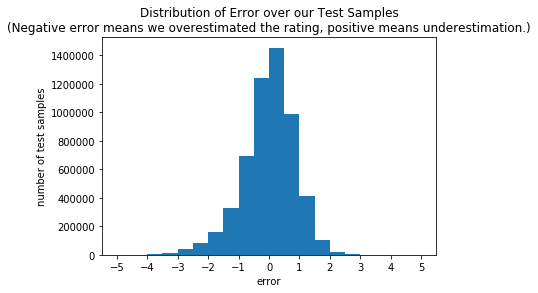

In [67]:
errors = list()
for i in test_indices: 
    user = user_to_id[users[i]]
    movie = movie_to_id[movies[i]]
    prediction = np.dot(p[user],q[movie])
    prediction += user_bias[user] + movie_bias[movie]
    prediction += average_rating
    errors.append(ratings[i] - prediction)
    
hist = plt.hist(np.array(errors),bins=np.arange(-5,5.5,.5))
plt.title('Distribution of Error over our Test Samples\n(Negative error means we overestimated the rating, positive means underestimation.)')
plt.xlabel('error')
plt.ylabel('number of test samples')
plt.xticks(np.arange(-5,6,1))
plt.show()

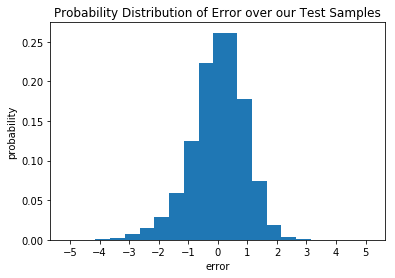

There is a 66.3 % chance of getting an absolute error <= 0.5
There is a 86.2 % chance of getting an absolute error <= 1
There is a 94.0 % chance of getting an absolute error <= 1.5
There is a 97.3 % chance of getting an absolute error <= 2


In [68]:
distribution = hist[0]
distribution /= sum(distribution)

plt.bar(np.arange(-4.75,5,.5),distribution)
plt.title('Probability Distribution of Error over our Test Samples')
plt.xlabel('error')
plt.ylabel('probability')
plt.xticks(np.arange(-5,6,1))
plt.show()

rating_to_id = dict(zip(hist[1],range(len(hist[1]))))
id_to_rating = dict(zip(range(len(hist[1])),hist[1]))

# returns probability that our error is between -abs_rating and abs_rating
def abs_proba(abs_rating):
    interval = np.arange(-abs_rating,abs_rating+.1,.5)
    return sum([distribution[rating_to_id[rating]] for rating in interval])

for abs_error in [.5,1,1.5,2]:
    proba = np.round(abs_proba(abs_error)*100,1)
    print('There is a',proba,'% chance of getting an absolute error <=',abs_error)